# S2-regrid-export-workflow

**Date:** <br>
23 November 2021 <br>
**Background:** <br>
Issue -  <br>
**Author(s):**<br>
Thomas Moore<br>

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
from dask_jobqueue import PBSCluster,SLURMCluster
from dask.distributed import Client
import numpy as np
import xrft
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
%config Completer.use_jedi = False

In [3]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

## OOD cluster

In [4]:
cluster = SLURMCluster(cores=16,memory="47GB")
client = Client(cluster)
client

Client Scheduler: tcp://10.0.128.157:32981 Dashboard: /proxy/39961/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
cluster.scale(cores=48)

In [8]:
client

Client Scheduler: tcp://10.0.128.157:32981 Dashboard: /proxy/39961/status,Cluster Workers: 12 Cores: 48 Memory: 141.00 GB


In [14]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -n 1
#SBATCH --cpus-per-task=16
#SBATCH --mem=44G
#SBATCH -t 00:30:00

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc_operational/bin/python -m distributed.cli.dask_worker tcp://10.0.128.152:40563 --nthreads 4 --nprocs 4 --memory-limit 11.75GB --name name --nanny --death-timeout 60



# Turn ON/OFF debugging

In [10]:
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'latt_bounds' in ds.data_vars:
        ds = ds.drop(['latt_bounds'])
    if 'lont_bounds' in ds.data_vars:
        ds = ds.drop(['lont_bounds'])    
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])
    if 'deptht_bounds' in ds.data_vars:
        ds = ds.drop(['deptht_bounds'])
    if 'areat' in ds.data_vars:
        ds = ds.drop(['areat'])        
    return ds

# SST, SSS, MLD1-2,d20,HC300,td

### load the whole timeseries using `drop` preproccessor

In [11]:
%%time
ds_SST_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_*.nc',parallel=True,preprocess=drop_not_in_2015)
#ds_SST_1981_2018 = xr.open_mfdataset(
#    [f'/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_{x}.nc' for x in range(year_start, year_end)],parallel=True,preprocess=drop_not_in_2015
#)

CPU times: user 4.68 s, sys: 1.23 s, total: 5.9 s
Wall time: 17.2 s


In [12]:
%%time
ds_SSS_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sss/mo_sss_*.nc',parallel=True,preprocess=drop_not_in_2015)

CPU times: user 4.37 s, sys: 961 ms, total: 5.33 s
Wall time: 14.9 s


In [13]:
%%time
ds_mld1_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld1/mo_mld1_*.nc',parallel=True,preprocess=drop_not_in_2015)

CPU times: user 4.09 s, sys: 950 ms, total: 5.04 s
Wall time: 13.2 s


In [14]:
%%time
ds_mld2_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld2/mo_mld2_*.nc',parallel=True,preprocess=drop_not_in_2015)

CPU times: user 3.91 s, sys: 1.01 s, total: 4.92 s
Wall time: 12.4 s


In [15]:
%%time
ds_D20_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/d20/mo_d20_*.nc',parallel=True,preprocess=drop_not_in_2015)

CPU times: user 4.13 s, sys: 949 ms, total: 5.08 s
Wall time: 13 s


In [16]:
%%time
ds_hc300_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/hc300/mo_hc300_*.nc',parallel=True,preprocess=drop_not_in_2015)

CPU times: user 3.91 s, sys: 1.02 s, total: 4.94 s
Wall time: 12.7 s


In [17]:
%%time
ds_td_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_*.nc',parallel=True,preprocess=drop_not_in_2015)

CPU times: user 3.87 s, sys: 872 ms, total: 4.74 s
Wall time: 13.8 s


In [18]:
%%time
ds_temp_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/temp/mo_temp_*.nc',parallel=True,preprocess=drop_not_in_2015)

CPU times: user 4.38 s, sys: 987 ms, total: 5.36 s
Wall time: 14.2 s


In [19]:
ds_temp50_1981_2018 = ds_temp_1981_2018.sel(deptht=50,method='nearest').rename({'temp':'temp50'})
ds_temp100_1981_2018 = ds_temp_1981_2018.sel(deptht=100,method='nearest').rename({'temp':'temp100'})
ds_temp200_1981_2018 = ds_temp_1981_2018.sel(deptht=200,method='nearest').rename({'temp':'temp200'})
ds_temp500_1981_2018 = ds_temp_1981_2018.sel(deptht=500,method='nearest').rename({'temp':'temp500'})

In [20]:
ds_ACCESS_S2_RA_ocean = xr.merge([ds_temp50_1981_2018.drop('deptht'),
                                  ds_temp100_1981_2018.drop('deptht'),
                                  ds_temp200_1981_2018.drop('deptht'),
                                  ds_temp500_1981_2018.drop('deptht'),
                                  ds_SST_1981_2018.squeeze(),
                                  ds_SSS_1981_2018.squeeze(),
                                  ds_mld1_1981_2018,
                                  ds_mld2_1981_2018,
                                  ds_D20_1981_2018,
                                  ds_hc300_1981_2018,
                                  ds_td_1981_2018
                                 ],compat='override')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('time_counter_bnds')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('deptht')
ds_ACCESS_S2_RA_ocean

<xarray.Dataset>
Dimensions:       (time_counter: 480, x: 1442, y: 1021)
Coordinates:
    nav_lat       (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... 2020-...
Dimensions without coordinates: x, y
Data variables:
    temp50        (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp100       (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp200       (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp500       (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    sst           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    sss           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld1          (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld2          (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    d20           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    hc300         (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    td            (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>

## add back in key metadata

In [21]:
areat = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_2016.nc',parallel=True)).areat.to_dataset()
areau = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_2016.nc',parallel=True)).areau.to_dataset()
areav = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_2016.nc',parallel=True)).areav.to_dataset()

In [22]:
ds_ACCESS_S2_RA_ocean = xr.combine_by_coords([ds_ACCESS_S2_RA_ocean,areat])
ds_ACCESS_S2_RA_ocean

<xarray.Dataset>
Dimensions:       (time_counter: 480, x: 1442, y: 1021)
Coordinates:
    nav_lat       (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... 2020-...
Dimensions without coordinates: x, y
Data variables:
    areat         (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    temp50        (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp100       (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp200       (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp500       (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    sst           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    sss           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld1          (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld2          (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    d20           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    hc300         (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    td            (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>

# Deal with the same depth coordinates given two different names & rename time

In [23]:
#ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'deptht':'depth','time_counter':'time'})
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'time_counter':'time'})

DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc611d51a60>
DEBUG:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc611d51a60> on colorbar
DEBUG:Setting pcolormesh


DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=9.9.
DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05
DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 norm

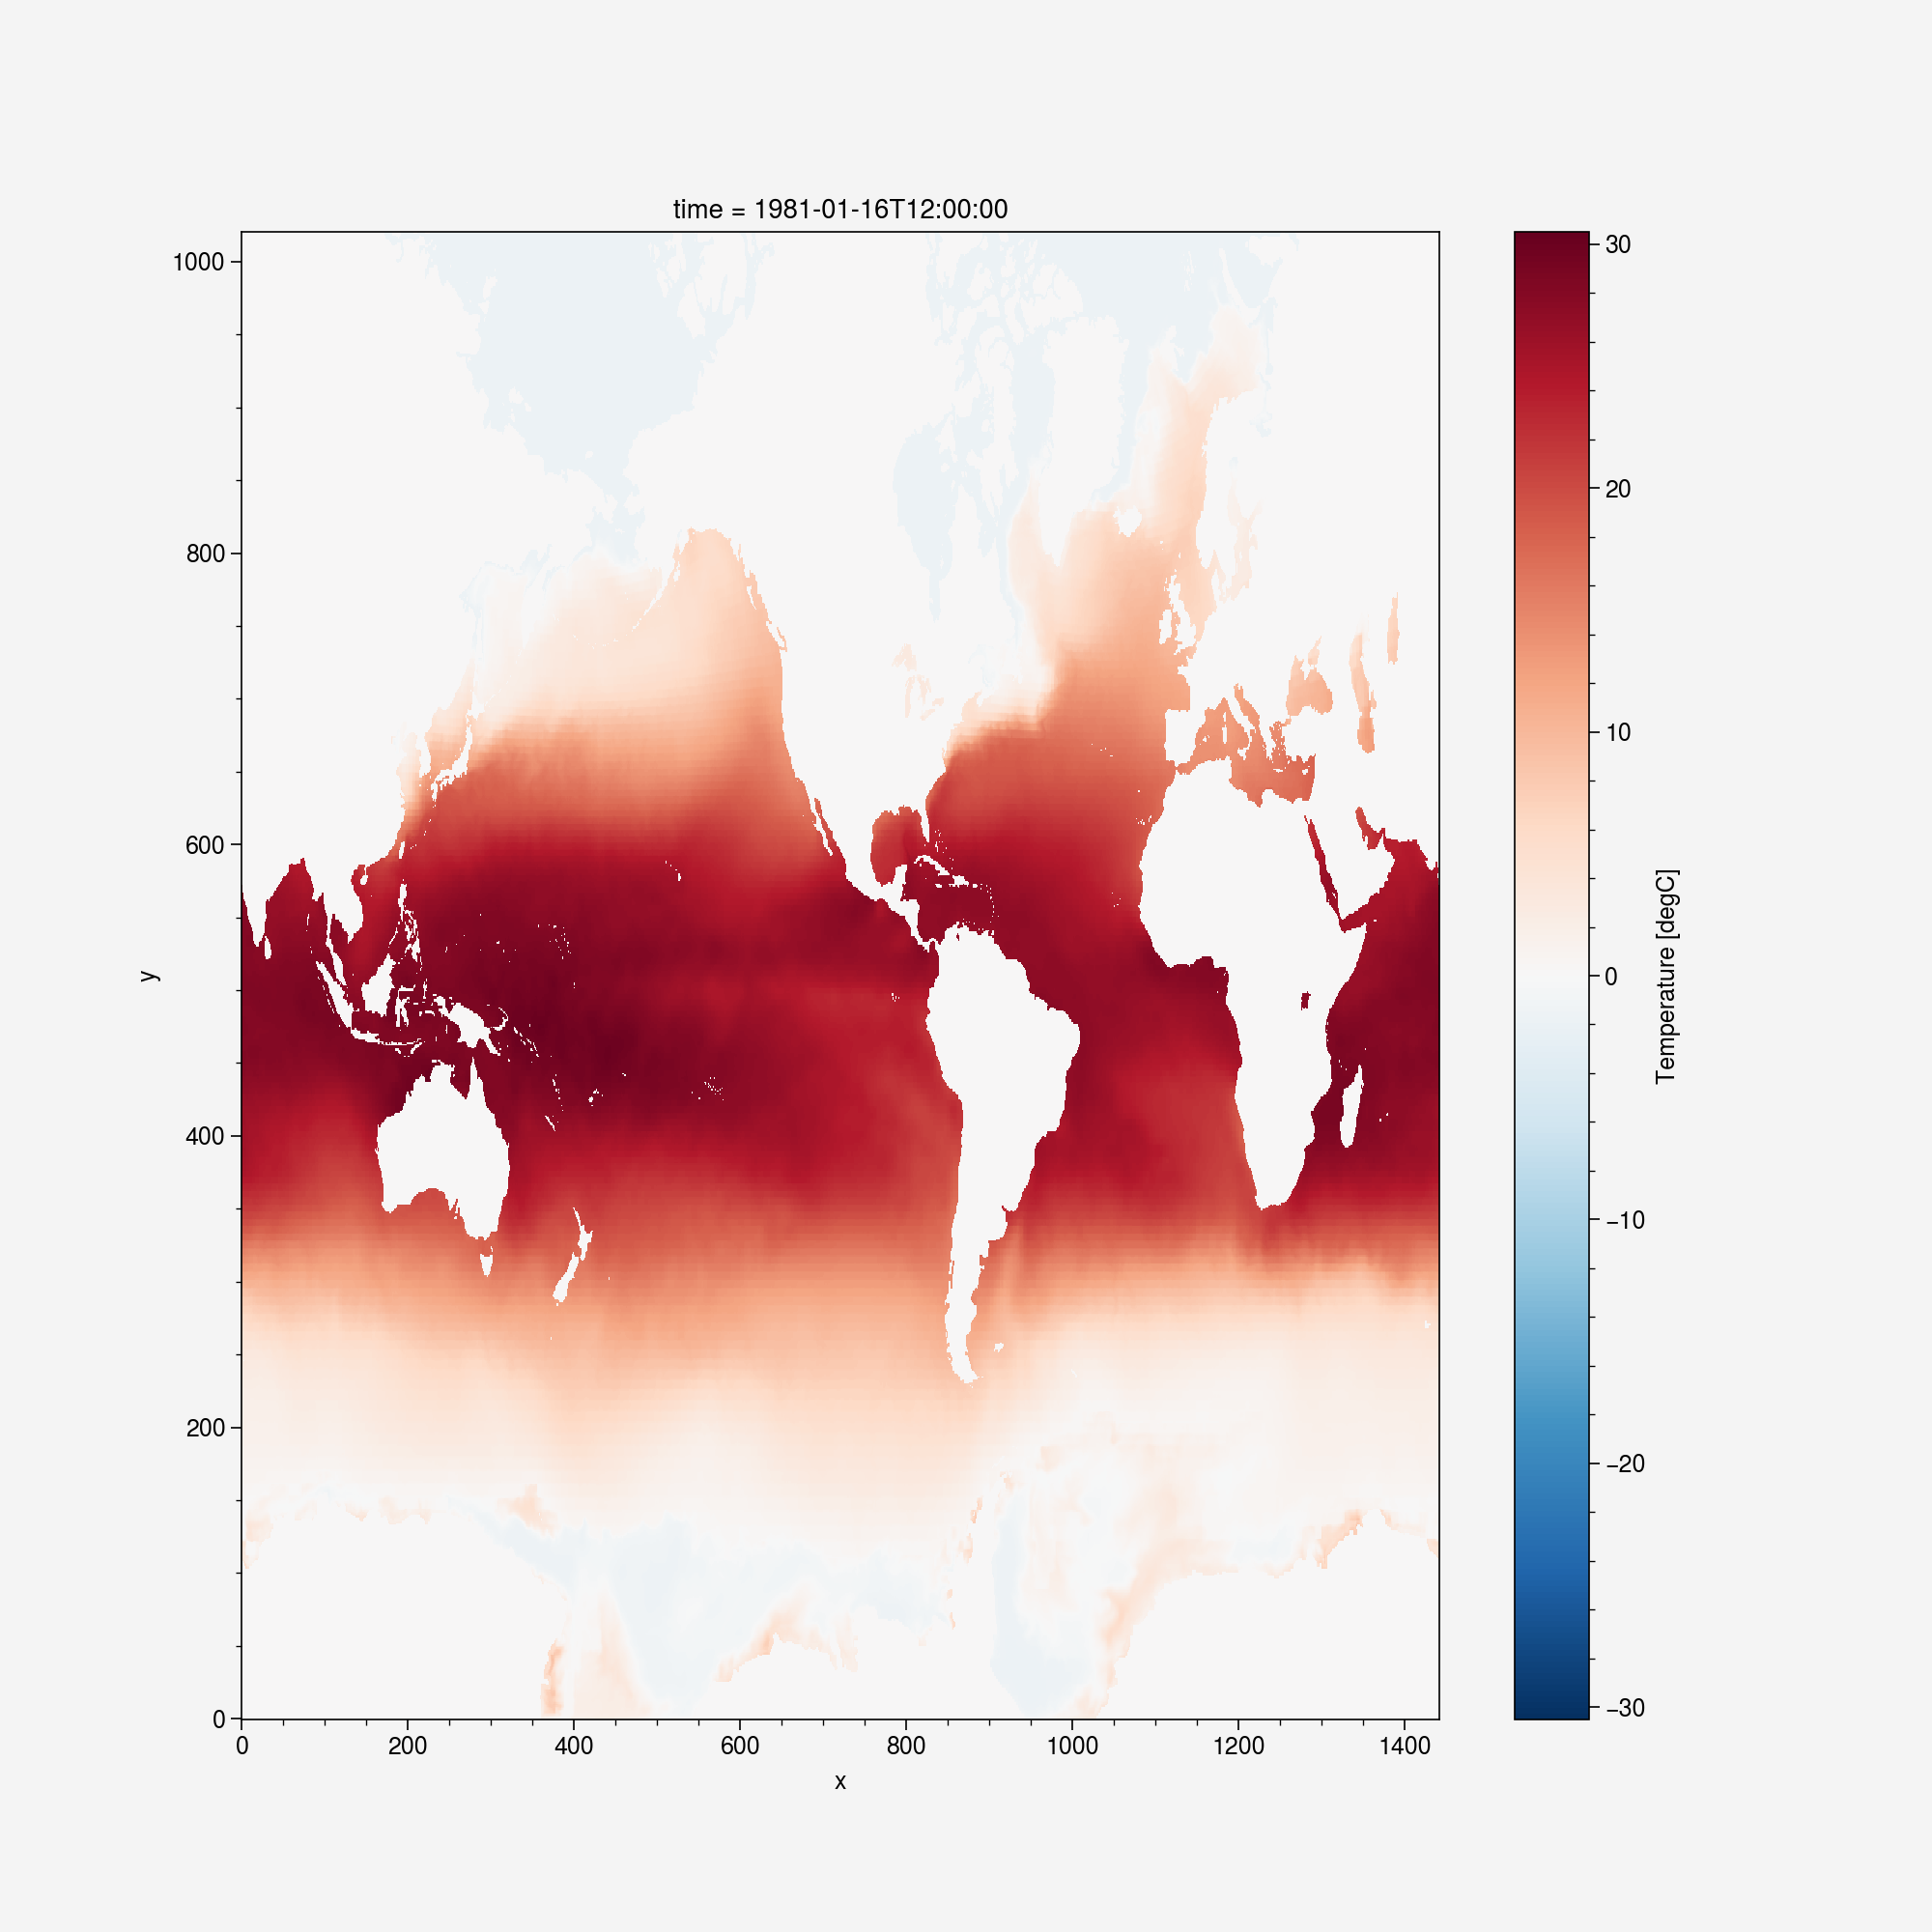

In [24]:
ds_ACCESS_S2_RA_ocean.sst.isel(time=0).plot(size = 10)

In [25]:
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
ds_ACCESS_S2_RA_ocean

<xarray.Dataset>
Dimensions:  (time: 480, x: 1442, y: 1021)
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2020-12-01T12:00:00
Dimensions without coordinates: x, y
Data variables:
    areat    (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    temp50   (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp100  (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp200  (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp500  (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    sst      (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    sss      (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld1     (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld2     (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    d20      (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    hc300    (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    td       (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>

In [26]:
ds_ACCESS_S2_RA_ocean.nbytes/1e9

31.112267064

# SAVE ocean tgrid zarr file

In [27]:
ds_ACCESS_S2_RA_ocean.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

KeyboardInterrupt: 

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip above
# $\Downarrow$

In [ ]:
ds_ACCESS_S2_RA_ocean_nativeTgrid = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

In [ ]:
%%time
ds_ACCESS_S2_RA_ocean_nativeTgrid.mld1.mean('time').plot(robust=True)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.ylim([200, 400])
plt.xlim([300, 500])
plt.xlabel('x')
plt.ylabel('y')
plt.title('mld1')

# memory // 16GB plus 160GB on cluster

In [ ]:
ds_ACCESS_S2_RA_ocean_nativeTgrid.nbytes/1e9

#### let's not persist this given crash on write
ds_ACCESS_S2_RA_ocean_nativeTgrid = ds_ACCESS_S2_RA_ocean_nativeTgrid.persist()

# Regridding Step

## curvilinear grid

In [ ]:
nav_lon = ds_ACCESS_S2_RA_ocean_nativeTgrid['lon'].compute()
nav_lat = ds_ACCESS_S2_RA_ocean_nativeTgrid['lat'].compute()

In [ ]:
plt.scatter(nav_lon, nav_lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.ylim([-80, 90])
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('ACCESS-S2 Curvilinear grid')

# CHOOSE YOUR NEW GRID // define uniform 1x1 grid

In [ ]:
new_1deg_grid = xe.util.grid_global(1, 1)
new_1deg_grid

In [ ]:
plt.scatter(new_1deg_grid.lon, new_1deg_grid.lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('uniform grid')

In [ ]:
%%time
regridder_S2_1deg_Tgrid = xe.Regridder(ds_ACCESS_S2_RA_ocean_nativeTgrid, new_1deg_grid,'bilinear', ignore_degenerate=True, periodic=True,reuse_weights=False)

## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the full dataset object

In [ ]:
%%time
regridder_S2_1deg_Tgrid._grid_in = None
regridder_S2_1deg_Tgrid._grid_out = None
ds_ACCESS_S2_RA_ocean_1degRegrid = regridder_S2_1deg_Tgrid(ds_ACCESS_S2_RA_ocean_nativeTgrid)

In [ ]:
ds_ACCESS_S2_RA_ocean_1degRegrid

In [ ]:
ds_ACCESS_S2_RA_ocean_1degRegrid = ds_ACCESS_S2_RA_ocean_1degRegrid.assign_coords({'x': ds_ACCESS_S2_RA_ocean_1degRegrid.lon.isel(y=0),'y': ds_ACCESS_S2_RA_ocean_1degRegrid.lat.isel(x=0)}).drop(['lon','lat']).rename({'x':'lon','y':'lat'})

In [ ]:
ds_ACCESS_S2_RA_ocean_1degRegrid.nbytes/1e9

## Sanity check

In [ ]:
%%time
regrid_data = ds_ACCESS_S2_RA_ocean_1degRegrid.mld1.mean(dim='time').compute()
coarsened_data = ds_ACCESS_S2_RA_ocean_nativeTgrid.mld1.mean(dim='time')
coarsened_data = coarsened_data.coarsen({'x':4,'y':4}, boundary="trim").mean().compute()

In [ ]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
fig.suptitle('compare regridded lon/lat to coarsened native x/y grid',fontsize=20)
regrid_data.plot(robust=True,ax=ax1)
coarsened_data.plot(robust=True,ax=ax2)
ax1.set_ylim([-60,0])
ax1.set_xlim([110,180])
ax2.set_ylim([50,125])
ax2.set_xlim([36,107])

# write 1deg Tgrid file to zarr

In [ ]:
%%time
ds_ACCESS_S2_RA_ocean_1degRegrid.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.Tregrid_1deg.zarr',consolidated=True)

# U & V

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip arrows if you can
# $\Downarrow$

# ACCESS-S2 ocean reanalysis (RA) 1981 - 2018

# load U & V S2_RA

In [ ]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_u_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_u_1981_2018

In [ ]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_v_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_v_1981_2018

# Deal with the same depth coordinates given two different names & rename time

In [ ]:
ds_u_1981_2018 = ds_u_1981_2018.rename({'depthu':'depth','time_counter':'time'})
ds_v_1981_2018 = ds_v_1981_2018.rename({'depthv':'depth','time_counter':'time'})

# rechunk the data to shrink chunks from 5GB to 100MB
**could use `rechunker` here?**

In [ ]:
u = ds_u_1981_2018.chunk({'time':456,'depth':1,'x':250,'y':250})
v = ds_v_1981_2018.chunk({'time':456,'depth':1,'x':250,'y':250})

# write U & V to zarr collections

In [ ]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.u.zarr
u.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.u.zarr',consolidated=True)

In [ ]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.v.zarr
v.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.v.zarr',consolidated=True)

# $\Downarrow$
# CAN SKIP TO THIS STEP IF U & V `ZARR` FILES ARE WRITTEN AND AVAILABLE
hard part for u & v done above

In [ ]:
u = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.u.zarr',consolidated=True)
v = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.v.zarr',consolidated=True)

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [ ]:
client.restart()

In [ ]:
def calc_EKE(u, v, time_name = 'time'):
    '''
    Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}
    u,v are x and y currents as an xarray data array
    '''
    u_mean = u.mean(time_name)
    v_mean = v.mean(time_name)
    MKE = 0.5*(u_mean**2 + v_mean**2).rename('MKE') # currents
    EKE = ( 0.5 * ((u-u_mean)**2 + (v-v_mean)**2) ).rename('EKE') # eddies
    return EKE, MKE

In [ ]:
u_da = u.u
v_da = v.v

In [ ]:
%%time
[EKE, MKE] = calc_EKE(u_da, v_da, time_name='time')

In [ ]:
KE = xr.merge([EKE,MKE])

In [ ]:
KE

In [ ]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.zarr
KE.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.zarr',consolidated=True)

# $\Downarrow$
# CAN SKIP TO THIS STEP IF EKE `ZARR` FILE IS WRITTEN AND AVAILABLE
hard part for u & v & EKE & MKE done above

In [ ]:
KE = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.zarr',consolidated=True)

In [ ]:
EKE_mean = KE.EKE.mean('time').compute()

# reduce dataset to surface only

In [ ]:
KE_surface = KE.isel(depth=0).compute()

In [ ]:
KE_surface.sel(x=slice(250,450),y=slice(250,450)).mean('time').EKE.plot(vmax=.05)

# write file to netcdf

In [ ]:
%%time
KE_surface.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE_surface.nc',mode='w')

In [ ]:
KE = KE.persist()

In [ ]:
%%time
KE.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.nc',mode='w')

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [30]:
client.restart()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


KeyboardInterrupt: 

In [29]:
client.shutdown()

DEBUG:Stopping worker: 1 job: 13380
DEBUG:Executing the following command to command line
scancel 13380
DEBUG:Closed job 13380
DEBUG:Stopping worker: 0 job: 13379
DEBUG:Executing the following command to command line
scancel 13379
DEBUG:Closed job 13379
DEBUG:Stopping worker: 2 job: 13378
DEBUG:Executing the following command to command line
scancel 13378
DEBUG:Closed job 13378
DEBUG:Executing the following command to command line
scancel 13379
DEBUG:Closed job 13379
DEBUG:Executing the following command to command line
scancel 13380
DEBUG:Closed job 13380
DEBUG:Executing the following command to command line
scancel 13378
DEBUG:Closed job 13378


In [ ]:
client.restart()